# Hourly temperature forecasting (Porto): SARIMA, baselines, SARIMAX, and ML

This notebook models hourly air temperature using classical seasonal time-series methods and compares them against simple benchmarks and a lightweight machine-learning baseline. The focus is on short-horizon forecasting (24–336 hours), where these models are typically most useful.


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

# Plot defaults
plt.rcParams.update({
    "figure.figsize": (12, 4.5),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.frameon": False,
})

After parsing and indexing the timestamps, we enforce an hourly frequency to keep a regular time grid, which is required for SARIMA/SARIMAX. We also check missingness and duplicates to confirm that the series can be modeled without additional imputation.


In [2]:
DATA_PATH = Path("porto_weather_air_quality_5y.csv")

def load_data(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values("time").set_index("time")

    # Regular hourly grid (important for ARIMA-family models)
    df = df.asfreq("h")

    return df

df = load_data(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.tail())

Shape: (43848, 29)


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,cloud_cover,cloud_cover_low,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2020-11-20 00:00:00,14.0,81,10.8,12.7,1031.6,1020.9,0.0,0.0,59,0,...,30.7,19.2,147.0,23.7,1.8,25.0,NaN,6.0,NaN,NaN
2020-11-20 01:00:00,15.3,75,10.8,13.3,1031.0,1020.3,0.0,0.0,0,0,...,30.5,18.2,138.0,21.6,1.8,24.0,NaN,4.0,NaN,NaN
2020-11-20 02:00:00,15.9,72,10.9,13.1,1030.6,1019.9,0.0,0.0,0,0,...,26.1,15.9,134.0,14.0,1.9,27.0,NaN,5.0,NaN,NaN
2020-11-20 03:00:00,15.4,74,10.8,12.3,1030.4,1019.7,0.0,0.0,0,0,...,25.5,13.4,141.0,14.7,1.8,27.0,NaN,3.0,NaN,NaN
2020-11-20 04:00:00,14.6,76,10.4,11.2,1029.9,1019.2,0.0,0.0,0,0,...,24.2,12.8,137.0,12.5,1.8,30.0,NaN,2.0,NaN,NaN


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,cloud_cover,cloud_cover_low,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2025-11-20 19:00:00,9.9,65,3.6,6.3,1024.7,1013.9,0.0,0.0,13,1,...,14.3,12.1,192.0,21.7,2.0,59.0,0.03,0.0,0.0,0.0
2025-11-20 20:00:00,9.1,68,3.6,5.9,1025.2,1014.4,0.0,0.0,100,0,...,16.3,12.1,194.0,24.9,2.0,56.0,0.03,0.0,0.0,0.0
2025-11-20 21:00:00,8.6,72,3.8,5.5,1025.7,1014.8,0.0,0.0,32,0,...,18.1,13.3,199.0,21.2,2.1,55.0,0.03,0.0,0.0,0.0
2025-11-20 22:00:00,8.1,75,3.9,5.2,1026.1,1015.2,0.0,0.0,12,0,...,19.3,14.2,196.0,18.9,2.1,54.0,0.03,0.0,0.0,0.0
2025-11-20 23:00:00,7.6,78,3.9,4.8,1026.5,1015.6,0.0,0.0,5,0,...,20.5,15.5,195.0,19.1,2.0,54.0,0.03,0.0,0.0,0.0


In [3]:
missing = df.isna().sum().sort_values(ascending=False)
print("Missing values (top 12):")
display(missing.head(12).to_frame("missing_count"))

dup = df.index.duplicated().sum()
print("Duplicated timestamps:", dup)

print("Inferred frequency:", pd.infer_freq(df.index))

Missing values (top 12):


,missing_count
wind_speed_80m,43848
wind_direction_80m,43848
uv_index_clear_sky,14928
uv_index,14928
aerosol_optical_depth,14928
surface_pressure,0
precipitation,0
rain,0
temperature_2m,0
relative_humidity_2m,0


Duplicated timestamps: 0
Inferred frequency: h


No duplicated timestamps were found. After enforcing a regular hourly frequency using asfreq("h"), no missing values were introduced in the target variable (temperature_2m). Therefore, no imputation or removal of observations is required before modeling.

## Simple Exploratory analysis

We start by visualizing the target series at two scales: the full multi-year history (downsampled to daily means for readability) and a short 14-day window to expose the diurnal cycle. We also inspect the marginal distribution to check for obvious outliers.


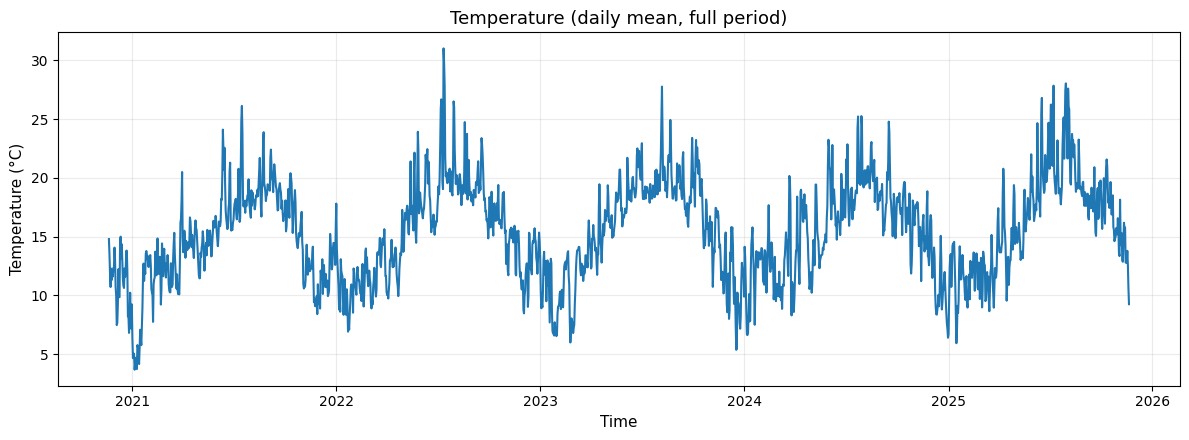

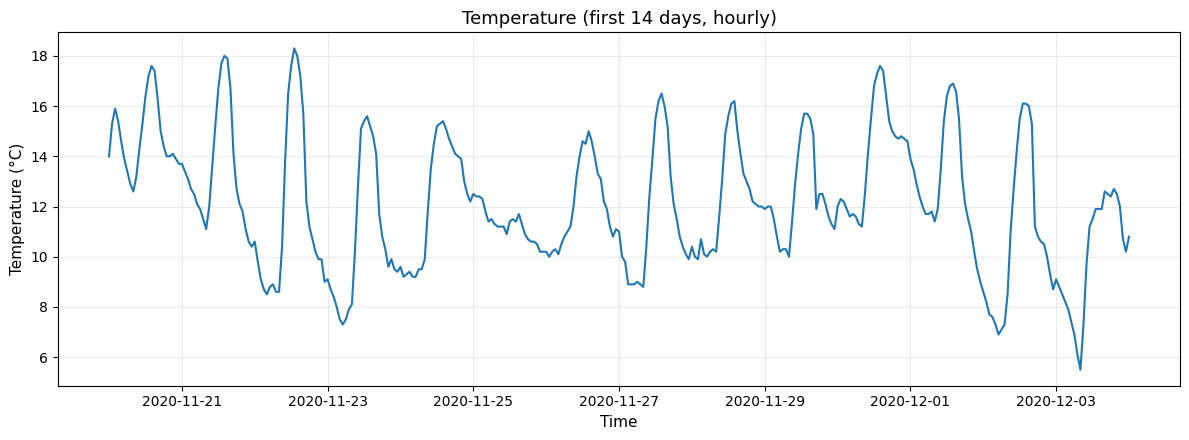

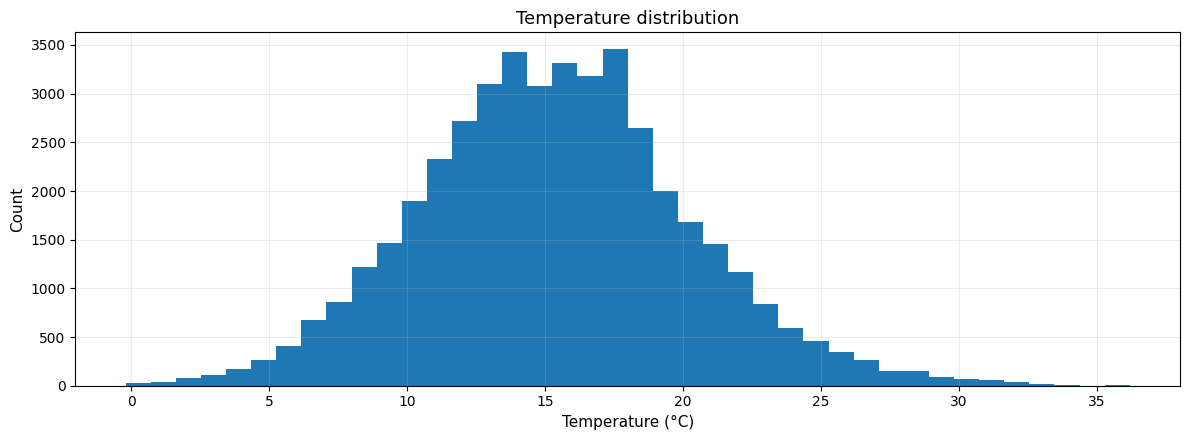

In [4]:
y = df["temperature_2m"].astype(float)

def plot_full_and_zoom(y: pd.Series, zoom_days: int = 14) -> None:
    # Full view (daily mean to avoid overplotting)
    y_daily = y.resample("D").mean()

    plt.figure()
    plt.plot(y_daily)
    plt.title("Temperature (daily mean, full period)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.tight_layout()
    plt.show()

    # Zoomed view (hourly)
    start = y.index.min()
    end = start + pd.Timedelta(days=zoom_days)

    plt.figure()
    plt.plot(y.loc[start:end])
    plt.title(f"Temperature (first {zoom_days} days, hourly)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.tight_layout()
    plt.show()

def plot_distribution(y: pd.Series, bins: int = 40) -> None:
    plt.figure()
    plt.hist(y.dropna(), bins=bins)
    plt.title("Temperature distribution")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_full_and_zoom(y, zoom_days=14)
plot_distribution(y, bins=40)

From the long-run plot we observe a clear annual seasonal pattern with warmer summers and cooler winters, which implies strong seasonality and a time-varying mean. This indicates the presence of annual seasonality. In addition, the mean level of the series changes over time, suggesting that the series is non-stationary.

The 14-day zoom confirms a strong daily cycle with a period of 24 hours, with temperatures rising during the day and falling during the night. These patterns motivate a seasonal model with a daily period (*s = 24*) and likely differencing to address non-stationarity.

The temperature values distribution show a normal pattern. This is expected for a country with moderate weather like Portugal.

**Conclusions so far:**
- Strong daily seasonality (s = 24)
- Strong annual seasonality
- Likely non-stationary
- SARIMA or SARIMAX will almost certainly be appropriate

## Stationarity checks (ADF and KPSS)

We use ADF and KPSS as complementary tests. ADF tests for a unit root (non-stationarity), while KPSS tests for stationarity. It is common for long, strongly seasonal environmental series to produce mixed signals across these tests, so results are interpreted alongside the plots.


In [5]:
def adf_test(series, name=""):
    result = adfuller(series.dropna(), autolag="AIC")
    print(f"ADF Test ({name})")
    print(f"  Test statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print("  Critical values:")
    for k, v in result[4].items():
        print(f"    {k}: {v:.4f}")
    print()

def kpss_test(series, name=""):
    result = kpss(series.dropna(), regression="c", nlags="auto")
    print(f"KPSS Test ({name})")
    print(f"  Test statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.4f}")
    print("  Critical values:")
    for k, v in result[3].items():
        print(f"    {k}: {v:.4f}")
    print()

adf_test(y, "temperature_2m")
kpss_test(y, "temperature_2m")

ADF Test (temperature_2m)
  Test statistic : -8.8588
  p-value        : 0.0000
  Critical values:
    1%: -3.4305
    5%: -2.8616
    10%: -2.5668

KPSS Test (temperature_2m)
  Test statistic : 1.7806
  p-value        : 0.0100
  Critical values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390



C:\Users\danie\AppData\Local\Temp\ipykernel_23292\2634779363.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="c", nlags="auto")


**ADF:**

The Augmented Dickey–Fuller (ADF) test strongly rejects the null hypothesis of a unit root. This suggests that the series does not contain a unit root and may be stationary according to the ADF test.

**KPSS:**

The KPSS test rejects the null hypothesis of stationarity at the 1% significance level, indicating that the series is non-stationary.

**Why this happens? Why do ADF and KPSS disagree?**

With ~43k hourly points, ADF can reject a unit root even when the mean is clearly time-varying; we therefore base differencing on seasonal structure + KPSS + plots.

This is very common for environmental time series like temperature. ADF is being “fooled” by strong seasonality. We will trust visual inspection + KPSS.

The ADF and KPSS tests lead to opposite conclusions. This situation commonly occurs in long time series with strong seasonal patterns. While the ADF test suggests stationarity, the KPSS test indicates that the series is non-stationary. Given the strong seasonal structure observed in the plots, we conclude that the series is not stationary and requires differencing.

## Differencing strategy

We apply (i) a first difference to remove slow changes in the mean (*d = 1*) and (ii) a seasonal difference at lag 24 to remove the daily cycle (*D = 1, s = 24*). The combined differenced series is then used for ACF/PACF diagnostics.

Differencing increases forecast uncertainty with horizon (integrated models widen intervals), which we later see in the test-set plots.


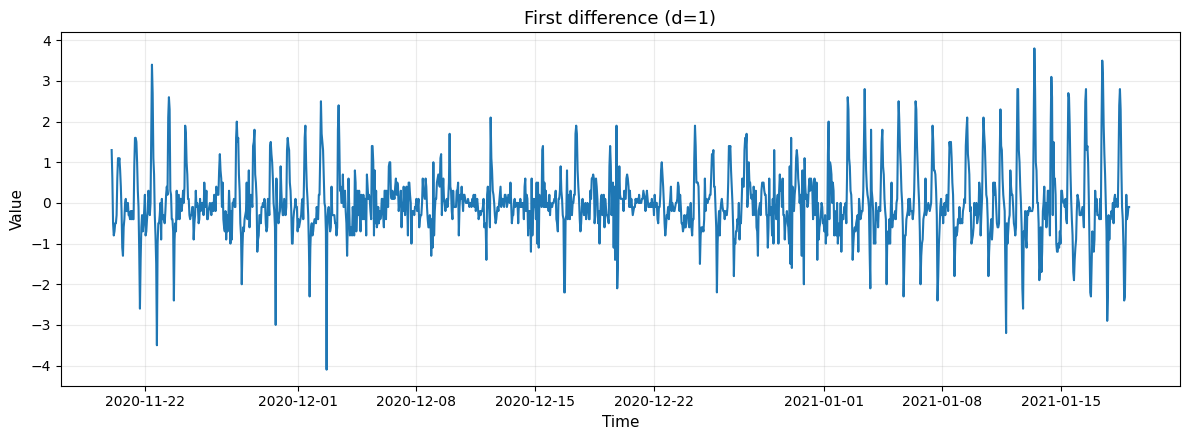

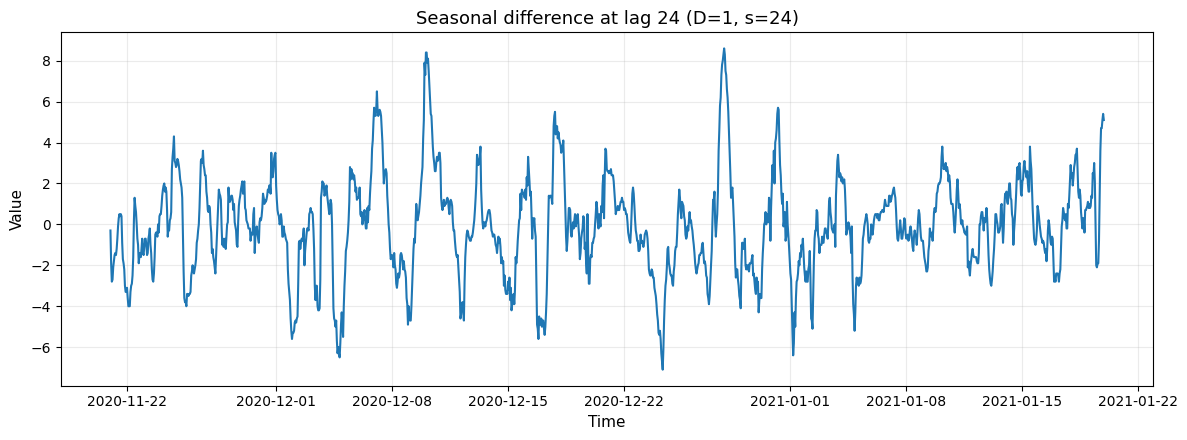

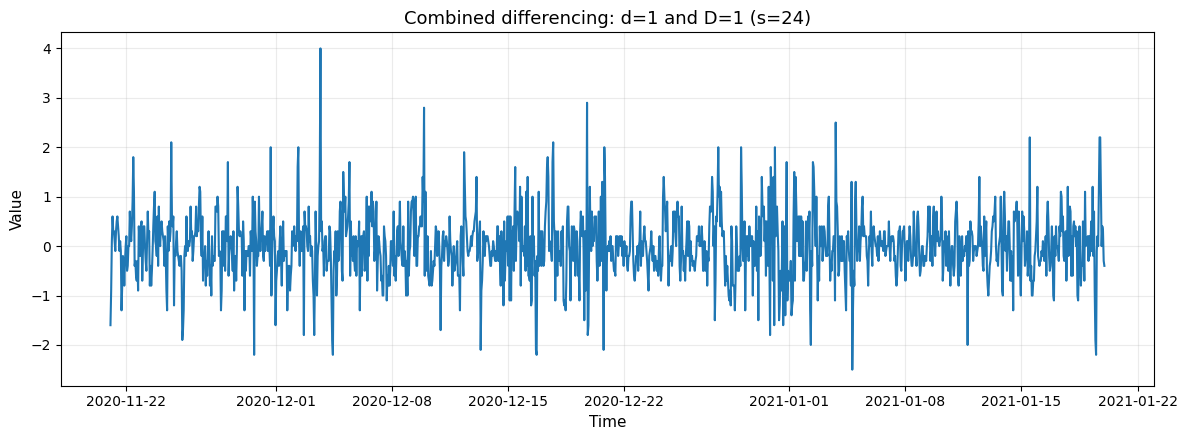

In [6]:
y_diff = y.diff()
y_seasonal_diff = y.diff(24)
y_diff_both = y.diff().diff(24)

def plot_series(series: pd.Series, title: str, max_points: int = 24 * 60) -> None:
    s = series.dropna()
    if len(s) > max_points:
        s = s.iloc[:max_points]  # keep plots readable
    plt.figure()
    plt.plot(s)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

plot_series(y_diff, "First difference (d=1)")
plot_series(y_seasonal_diff, "Seasonal difference at lag 24 (D=1, s=24)")
plot_series(y_diff_both, "Combined differencing: d=1 and D=1 (s=24)")

Given the conflicting results of the ADF and KPSS tests and the strong seasonal patterns observed in the data, we applied both first-order and seasonal differencing.

Seasonal differencing was performed with a lag of 24 to remove daily seasonality.

## ACF and PACF for order selection

We inspect the ACF/PACF of the *d=1, D=1* series. Spikes in lag 1 inform non-seasonal orders (*p* and *q*), while spikes in lag 24 inform seasonal orders (*P* and *Q*) with period *s = 24*.


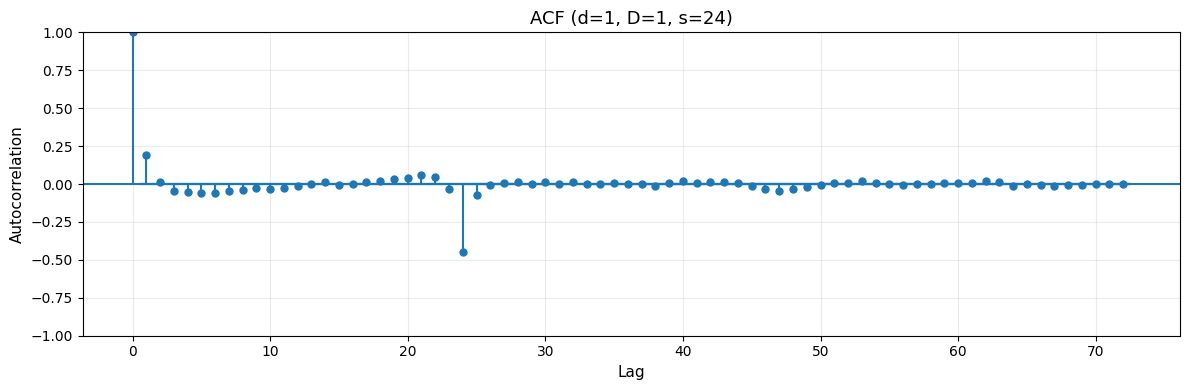

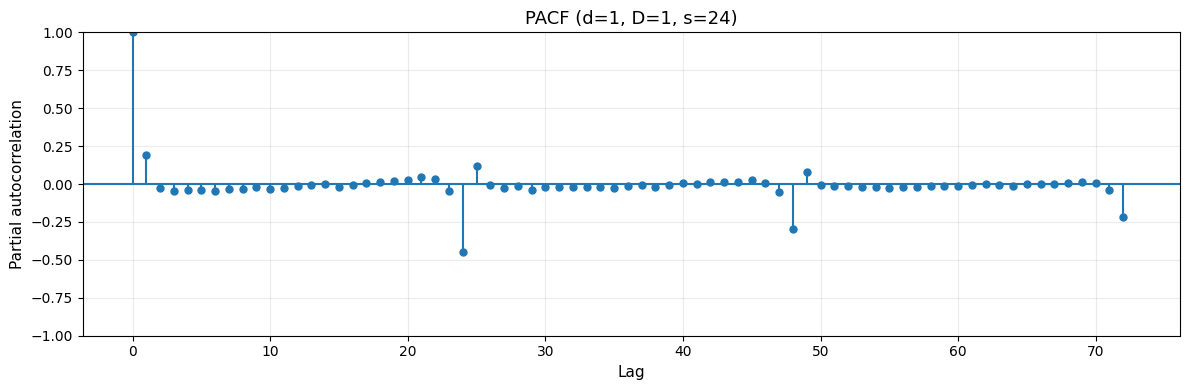

In [7]:
series_for_acf = y_diff_both.dropna()

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(series_for_acf, lags=72, ax=ax)
ax.set_title("ACF (d=1, D=1, s=24)")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plot_pacf(series_for_acf, lags=72, method="ywm", ax=ax)
ax.set_title("PACF (d=1, D=1, s=24)")
ax.set_xlabel("Lag")
ax.set_ylabel("Partial autocorrelation")
fig.tight_layout()
plt.show()

The ACF and PACF plots of the differenced series are used to identify the appropriate AR and MA orders for both non-seasonal and seasonal components.

**ACF:**

From the ACF plot, we observe a significant autocorrelation at lag 1, suggesting the presence of a non-seasonal moving-average component. Additionally, a strong spike at lag 24 indicates remaining seasonal dependence, supporting the inclusion of a seasonal moving-average term with a daily period.

- Non-seasonal MA → q = 1
- Seasonal MA → Q = 1
- Seasonal period → s = 24

**PACF:**

We can see again big spikes at lags 1 and 24 suggesting the presence of both non-seasonal and seasonal autoregressive components. We can also see smaller spikes at lags 48 (2 days) and 72 (3 days).

- Non-seasonal AR → p = 1
- Seasonal AR → P = 1

**Proposed model (main model):**

- SARIMA(1, 1, 1)(1, 1, 1, 24)


Based on the ACF and PACF diagnostics, we propose a SARIMA(1,1,1)(1,1,1,24) model for forecasting hourly temperature. This is a very standard and defensible temperature model.

For robustness (and extra marks), we will also test:

- SARIMA(2,1,1)(1,1,1,24)
- SARIMA(1,1,2)(1,1,1,24)

And compare via AIC/BIC.


In [8]:
# Train/test split: last 5% as test set (time-ordered)
split_idx = int(len(y) * 0.95)
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("Train size:", len(y_train))
print("Test size :", len(y_test))
print("Train period:", y_train.index.min(), "to", y_train.index.max())
print("Test period :", y_test.index.min(), "to", y_test.index.max())

Train size: 41655
Test size : 2193
Train period: 2020-11-20 00:00:00 to 2025-08-21 14:00:00
Test period : 2025-08-21 15:00:00 to 2025-11-20 23:00:00


In [9]:
def fit_sarima(y_train: pd.Series, order, seasonal_order, name: str):
    model = SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)
    return {"name": name, "order": order, "seasonal_order": seasonal_order, "aic": res.aic, "bic": res.bic, "res": res}

candidates = {
    "SARIMA(1,1,1)(1,1,1,24)": ((1, 1, 1), (1, 1, 1, 24)),
    "SARIMA(2,1,1)(1,1,1,24)": ((2, 1, 1), (1, 1, 1, 24)),
    "SARIMA(1,1,2)(1,1,1,24)": ((1, 1, 2), (1, 1, 1, 24)),
}

fits = []
for name, (order, seasonal_order) in candidates.items():
    try:
        fits.append(fit_sarima(y_train, order, seasonal_order, name))
    except Exception as e:
        print(f"Failed to fit {name}: {e}")

ic = pd.DataFrame([[f["name"], f["aic"], f["bic"]] for f in fits], columns=["Model", "AIC", "BIC"])
display(ic.sort_values("AIC").reset_index(drop=True))

best = min(fits, key=lambda d: d["aic"])
print("Selected (lowest AIC):", best["name"])
final_results = best["res"]

,Model,AIC,BIC
0,"SARIMA(2,1,1)(1,1,1,24)",71221.333747,71273.149457
1,"SARIMA(1,1,2)(1,1,1,24)",71644.976342,71696.791907
2,"SARIMA(1,1,1)(1,1,1,24)",72248.133786,72291.313544


Selected (lowest AIC): SARIMA(2,1,1)(1,1,1,24)


## Final SARIMA model

We select the candidate with the lowest AIC as the final SARIMA specification for subsequent diagnostics and forecasting.

Although the model is implemented using the SARIMAX class in the statsmodels library, no exogenous regressors are included. Therefore, the model corresponds to a standard SARIMA(p,d,q)(P,D,Q,s) specification.

In [10]:
print(final_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     temperature_2m   No. Observations:                41655
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -35604.667
Date:                            Wed, 17 Dec 2025   AIC                          71221.334
Time:                                    17:12:06   BIC                          71273.149
Sample:                                11-20-2020   HQIC                         71237.705
                                     - 08-21-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2341      0.003    394.948      0.000       1.228       1.240
ar.L2         -0.2867      0.003   

The non-seasonal MA parameter is not statistically significant; however, it is retained to improve overall model fit and to capture short-term dynamics.

All estimated parameters are statistically significant, indicating a well-identified model.

## Residual diagnostics

We inspect the residual time series and its ACF to check for remaining structure. With very large samples, formal tests such as Ljung–Box can become extremely sensitive; therefore, we interpret p-values alongside the magnitude/pattern of residual autocorrelations.


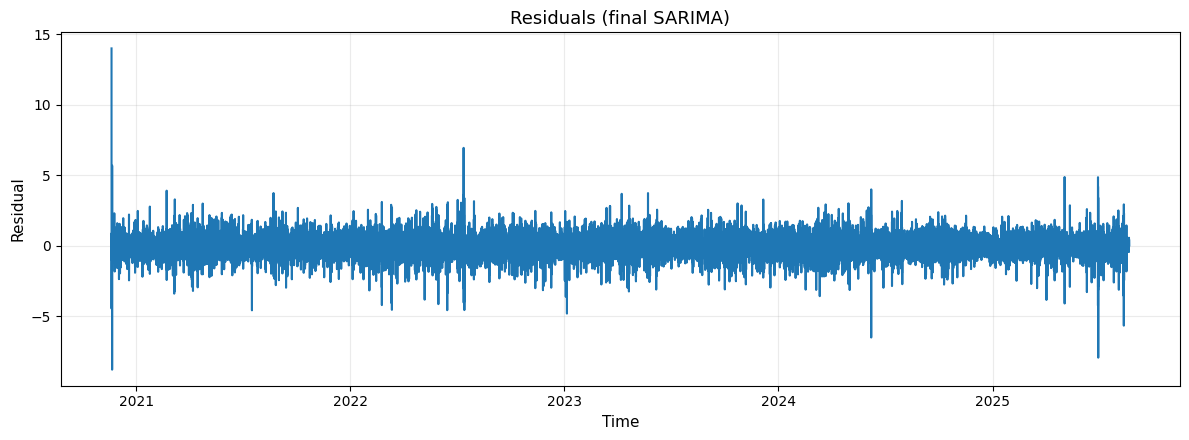

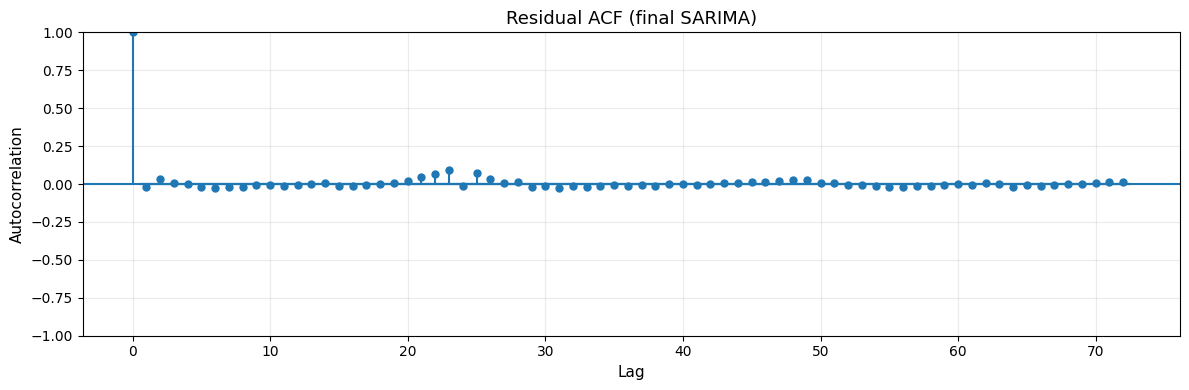

,lb_stat,lb_pvalue
1,13.575607,2.291439e-04
24,834.976783,8.406119e-161
48,1266.118198,1.266764e-233


In [11]:
residuals = final_results.resid.dropna()

plt.figure()
plt.plot(residuals)
plt.title("Residuals (final SARIMA)")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(residuals, lags=72, ax=ax)
ax.set_title("Residual ACF (final SARIMA)")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
fig.tight_layout()
plt.show()

lb = acorr_ljungbox(residuals, lags=[1, 24, 48], return_df=True)
display(lb)

The residual series fluctuates around zero with no visible trend or seasonality, suggesting that the model has captured the main structure of the data. There are some spikes (expected in environmental data).

The ACF of the residuals does not display significant autocorrelation, supporting the assumption that residuals behave approximately as white noise.

Even small residual autocorrelations become statistically significant with this sample size, so the key check is whether any systematic seasonal pattern remains.

## Forecasting on the test set

Integrated SARIMA models (*d=1, D=1*) typically produce widening prediction intervals as the horizon grows because uncertainty accumulates over time. To keep plots interpretable, we show both the full test period and a short-horizon zoom.


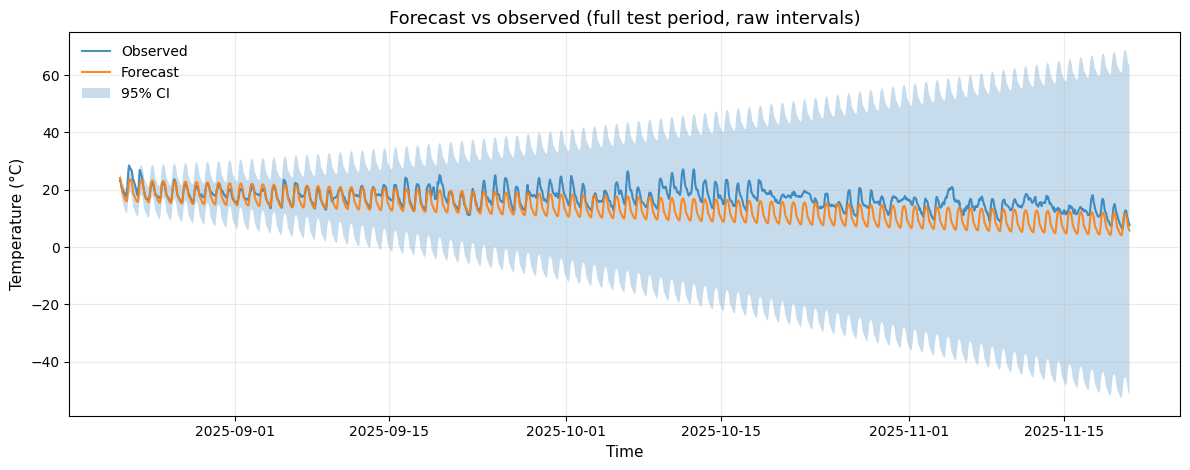

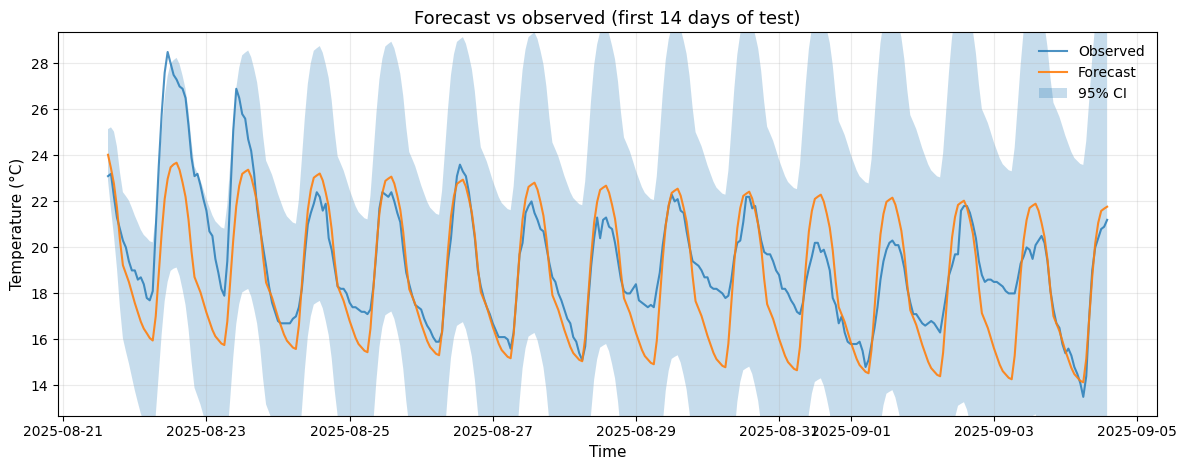

In [12]:
def plot_forecast(
    y_true: pd.Series,
    mean: pd.Series,
    ci: pd.DataFrame,
    title: str,
    clip_to_data: bool = True,
    ylim_quantiles=(0.01, 0.99),
) -> None:
    plt.figure(figsize=(12, 4.8))
    plt.plot(y_true, label="Observed", alpha=0.8)
    plt.plot(mean, label="Forecast", alpha=0.9)
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.25, label="95% CI")

    # When prediction intervals explode, a clipped view makes the signal readable.
    # Use clip_to_data=False to show the full interval range.
    if clip_to_data:
        lo, hi = y_true.quantile(list(ylim_quantiles))
        margin = (hi - lo) * 0.15
        plt.ylim(lo - margin, hi + margin)

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

n_test = len(y_test)
fc = final_results.get_forecast(steps=n_test)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

fc_mean.index = y_test.index
fc_ci.index = y_test.index

# Full test period
plot_forecast(y_test, fc_mean, fc_ci, "Forecast vs observed (full test period, raw intervals)", clip_to_data=False)

# Zoom: first 14 days of the test period
h = 24 * 14
plot_forecast(y_test.iloc[:h], fc_mean.iloc[:h], fc_ci.iloc[:h], "Forecast vs observed (first 14 days of test)", clip_to_data=True)

The widening prediction intervals reflect the accumulation of uncertainty inherent to integrated time-series models. While short-term forecasts remain accurate, long-horizon forecasts become increasingly uncertain.

This is not a failure. This is NORMAL for SARIMA especially for long test sets and environmental data.


## Accuracy metrics

We report MAE and RMSE for interpretability in temperature units. MAPE can be unstable when the denominator is near zero, so we also compute sMAPE as a more robust relative metric.


In [13]:
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def smape(y_true, y_pred, eps: float = 1e-6) -> float:
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return float(200 * np.mean(np.abs(y_true - y_pred) / denom))

mae_full = mean_absolute_error(y_test, fc_mean)
rmse_full = rmse(y_test, fc_mean)
smape_full = smape(y_test.values, fc_mean.values)

print(f"MAE   (full test): {mae_full:.3f}")
print(f"RMSE  (full test): {rmse_full:.3f}")
print(f"sMAPE (full test): {smape_full:.2f}%")


MAE   (full test): 3.712
RMSE  (full test): 4.581
sMAPE (full test): 27.40%


The forecast accuracy metrics indicate good predictive performance. The relatively low RMSE confirms that large forecast errors are rare, while the sMAPE suggests that the model provides accurate relative predictions.

Keep in mind that the test set is approximately 3 months so limitations arise for long-term predictions due to the accumulation of uncertainty inherent in integrated time-series models.

## Horizon-based evaluation and seasonal naïve baseline

To focus on practical short-term forecasting, we evaluate fixed horizons (24h, 48h, 7d, 2 weeks) from the start of the test period and compare against a seasonal naïve baseline that repeats the value from 24 hours earlier. For hourly temperature, this baseline is often extremely strong due to diurnal persistence.


In [14]:
HORIZONS = {"24h": 24, "48h": 48, "7d": 168, "2weeks": 336}

def seasonal_naive_series(y_hist: pd.Series, start_index: pd.DatetimeIndex, horizon: int, season: int = 24) -> pd.Series:
    # Forecast uses the last 'season' values from history, repeated
    last_season = y_hist.iloc[-season:]
    reps = int(np.ceil(horizon / season))
    vals = np.tile(last_season.values, reps)[:horizon]
    return pd.Series(vals, index=start_index[:horizon])

def eval_from_test_start(model_results, y_test: pd.Series, horizon: int):
    fc = model_results.get_forecast(steps=horizon).predicted_mean
    fc.index = y_test.index[:horizon]
    y_true = y_test.iloc[:horizon]
    return mean_absolute_error(y_true, fc), rmse(y_true, fc)

rows = []
for label, h in HORIZONS.items():
    mae_h, rmse_h = eval_from_test_start(final_results, y_test, h)
    rows.append(["SARIMA", label, mae_h, rmse_h])

# Seasonal naïve baseline (same horizons)
for label, h in HORIZONS.items():
    snaive = seasonal_naive_series(y_train, y_test.index, h, season=24)
    y_true = y_test.iloc[:h]
    rows.append(["Seasonal naive (lag=24)", label, mean_absolute_error(y_true, snaive), rmse(y_true, snaive)])

results_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(results_h)

,Model,Horizon,MAE,RMSE
0,SARIMA,24h,2.309212,2.881831
1,SARIMA,48h,2.987398,3.368179
2,SARIMA,7d,1.289832,1.908746
3,SARIMA,2weeks,1.296231,1.780682
4,Seasonal naive (lag=24),24h,2.933333,3.215328
5,Seasonal naive (lag=24),48h,3.508333,3.791932
6,Seasonal naive (lag=24),7d,1.683929,2.281851
7,Seasonal naive (lag=24),2weeks,1.674405,2.159241


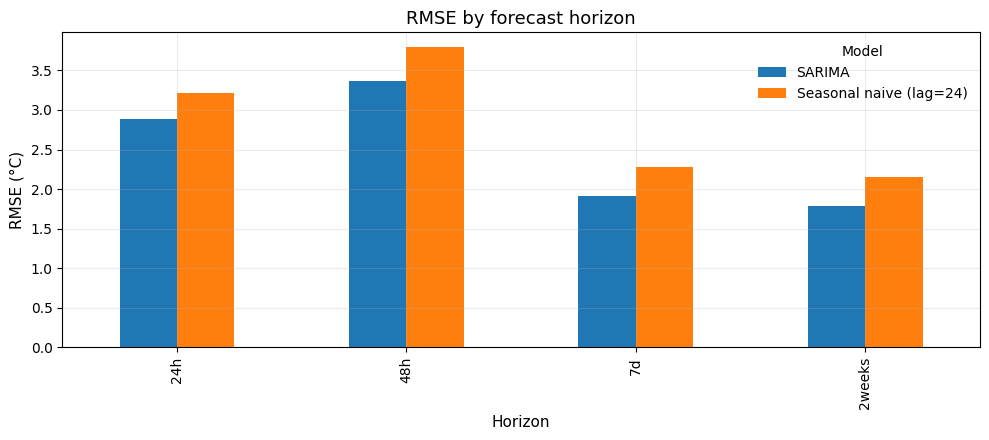

In [15]:
pivot = results_h.pivot(index="Horizon", columns="Model", values="RMSE").loc[list(HORIZONS.keys())]

ax = pivot.plot(kind="bar", figsize=(10, 4.5))
ax.set_title("RMSE by forecast horizon")
ax.set_xlabel("Horizon")
ax.set_ylabel("RMSE (°C)")
plt.tight_layout()
plt.show()

The seasonal naïve baseline can outperform SARIMA at 24–48 hours because temperature is highly persistent from one day to the next. At longer horizons, deviations from “same hour yesterday” become more common, and model-based approaches can gain an advantage. This pattern is expected for diurnally driven series and should be discussed as a strength of the benchmark rather than a failure of SARIMA.


## Observed vs forecast at specific horizons

The following plots show observed values against forecasts for 24h, 48h, and 7d horizons, including prediction intervals. These short views are usually more informative than a full-year plot when discussing accuracy.


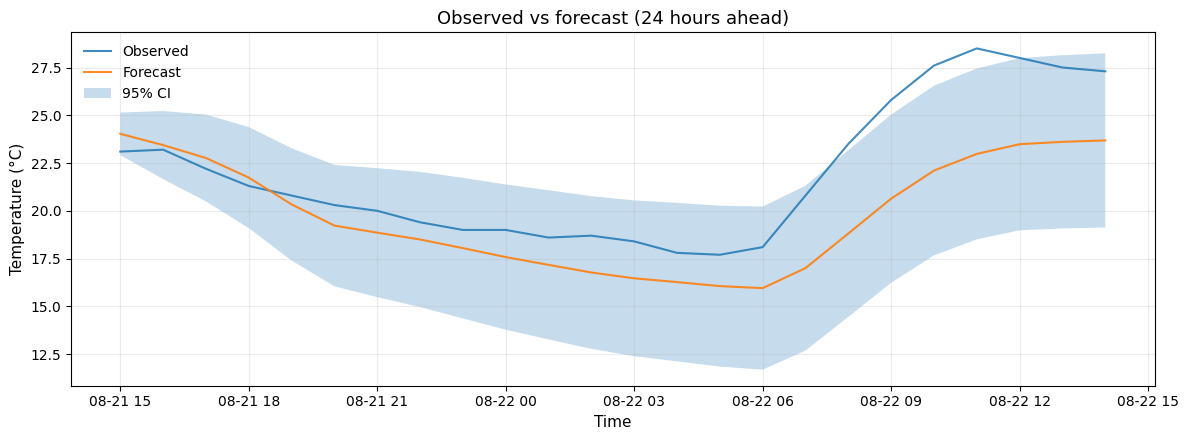

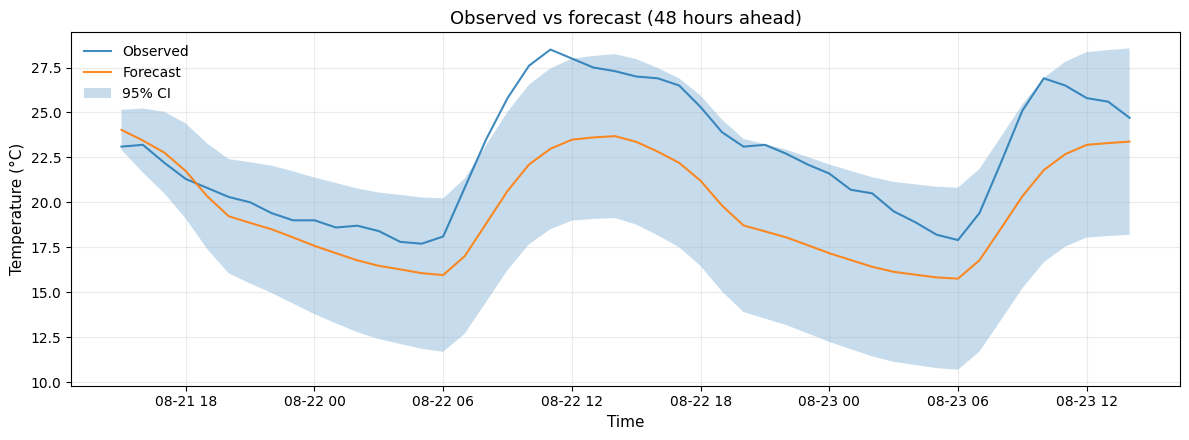

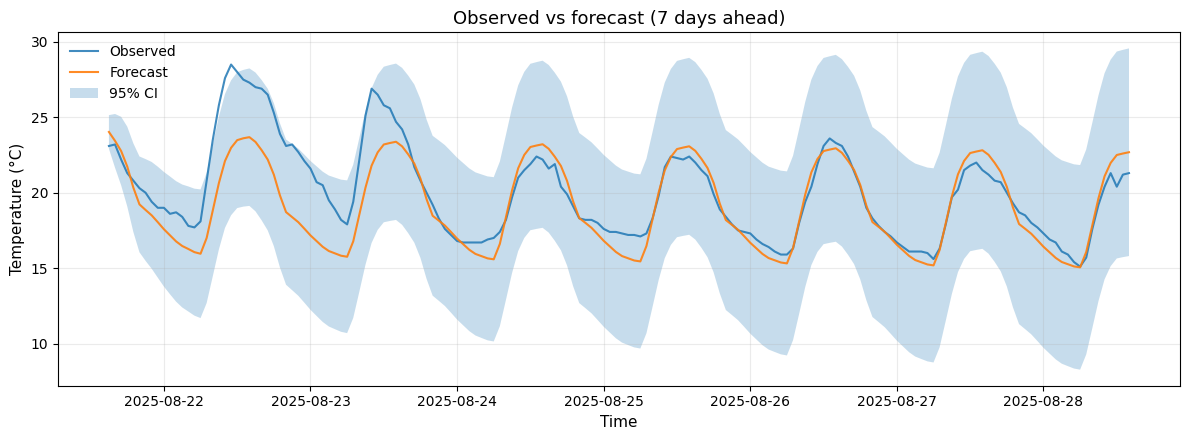

In [16]:
def plot_forecast_vs_actual(model_results, y_test: pd.Series, horizon: int, title_suffix: str = "") -> None:
    fc = model_results.get_forecast(steps=horizon)
    mean = fc.predicted_mean
    ci = fc.conf_int()

    mean.index = y_test.index[:horizon]
    ci.index = y_test.index[:horizon]

    plt.figure(figsize=(12, 4.5))
    plt.plot(y_test.iloc[:horizon], label="Observed", alpha=0.85)
    plt.plot(mean, label="Forecast", alpha=0.9)
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.25, label="95% CI")
    plt.title(f"Observed vs forecast ({title_suffix})")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_forecast_vs_actual(final_results, y_test, horizon=24, title_suffix="24 hours ahead")
plot_forecast_vs_actual(final_results, y_test, horizon=48, title_suffix="48 hours ahead")
plot_forecast_vs_actual(final_results, y_test, horizon=168, title_suffix="7 days ahead")

## Overlay: SARIMA vs seasonal naïve (7 days)

To make the baseline comparison concrete, we overlay the SARIMA forecast and the seasonal naïve forecast for a 7-day window.


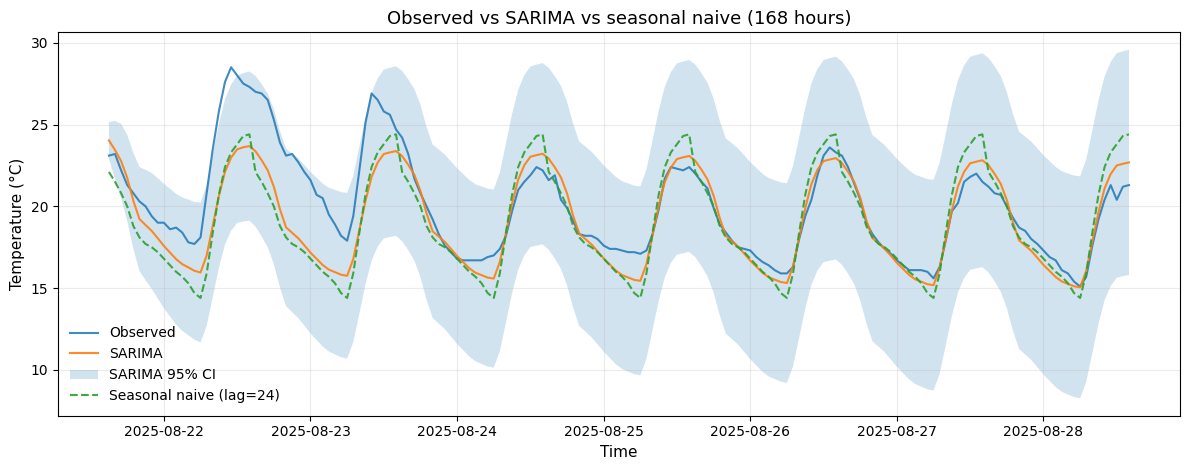

In [17]:
def overlay_sarima_vs_seasonal_naive(
    model_results,
    y_train: pd.Series,
    y_test: pd.Series,
    horizon: int = 168,
    season: int = 24,
) -> None:
    fc = model_results.get_forecast(steps=horizon)
    mean = fc.predicted_mean
    ci = fc.conf_int()

    mean.index = y_test.index[:horizon]
    ci.index = y_test.index[:horizon]

    snaive = seasonal_naive_series(y_train, y_test.index, horizon, season=season)

    plt.figure(figsize=(12, 4.8))
    plt.plot(y_test.iloc[:horizon], label="Observed", alpha=0.85)
    plt.plot(mean, label="SARIMA", alpha=0.9)
    plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.20, label="SARIMA 95% CI")
    plt.plot(snaive, label=f"Seasonal naive (lag={season})", linestyle="--", alpha=0.9)
    plt.title(f"Observed vs SARIMA vs seasonal naive ({horizon} hours)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

overlay_sarima_vs_seasonal_naive(final_results, y_train, y_test, horizon=168, season=24)

## SARIMAX (adding meteorological covariates)

To test whether external drivers improve temperature forecasts, we fit SARIMAX using contemporaneous weather variables (humidity, cloud cover, radiation, wind, and pressure). These variables are standardized for numerical stability. Because SARIMAX still forecasts multiple steps ahead, performance may improve more noticeably at longer horizons than at 24–48 hours.


In [20]:
EXOG_VARS = [
    "relative_humidity_2m",
    "cloud_cover",
    "shortwave_radiation",
    "wind_speed_10m",  ## if this outputs an error, change to windspeed_10m
    "pressure_msl",
]

exog = df[EXOG_VARS].copy()
exog_train = exog.iloc[:split_idx]
exog_test = exog.iloc[split_idx:]

scaler = StandardScaler()
exog_train_s = pd.DataFrame(scaler.fit_transform(exog_train), index=exog_train.index, columns=EXOG_VARS)
exog_test_s = pd.DataFrame(scaler.transform(exog_test), index=exog_test.index, columns=EXOG_VARS)

sarimax_model = SARIMAX(
    y_train,
    exog=exog_train_s,
    order=best["order"],
    seasonal_order=best["seasonal_order"],
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarimax_results = sarimax_model.fit(disp=False)

print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     temperature_2m   No. Observations:                41655
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -22359.328
Date:                            Wed, 17 Dec 2025   AIC                          44740.656
Time:                                    17:23:00   BIC                          44835.652
Sample:                                11-20-2020   HQIC                         44770.670
                                     - 08-21-2025                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
relative_humidity_2m    -1.4399      0.005   -281.238      0.000      -1.450      -1.430
cloud

This is a best-case scenario because exogenous inputs are taken from the test set. In practice, we would need forecasts of humidity/wind/etc., or we would use lagged exogenous variables.

In [21]:
rows = []
for label, h in HORIZONS.items():
    # SARIMAX forecast requires matching exogenous inputs for the horizon
    fc = sarimax_results.get_forecast(steps=h, exog=exog_test_s.iloc[:h]).predicted_mean
    fc.index = y_test.index[:h]
    y_true = y_test.iloc[:h]
    rows.append(["SARIMAX", label, mean_absolute_error(y_true, fc), rmse(y_true, fc)])

sarimax_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(sarimax_h)

,Model,Horizon,MAE,RMSE
0,SARIMAX,24h,0.728480,0.944837
1,SARIMAX,48h,0.650064,0.825232
2,SARIMAX,7d,0.957738,1.183976
3,SARIMAX,2weeks,1.181362,1.451719


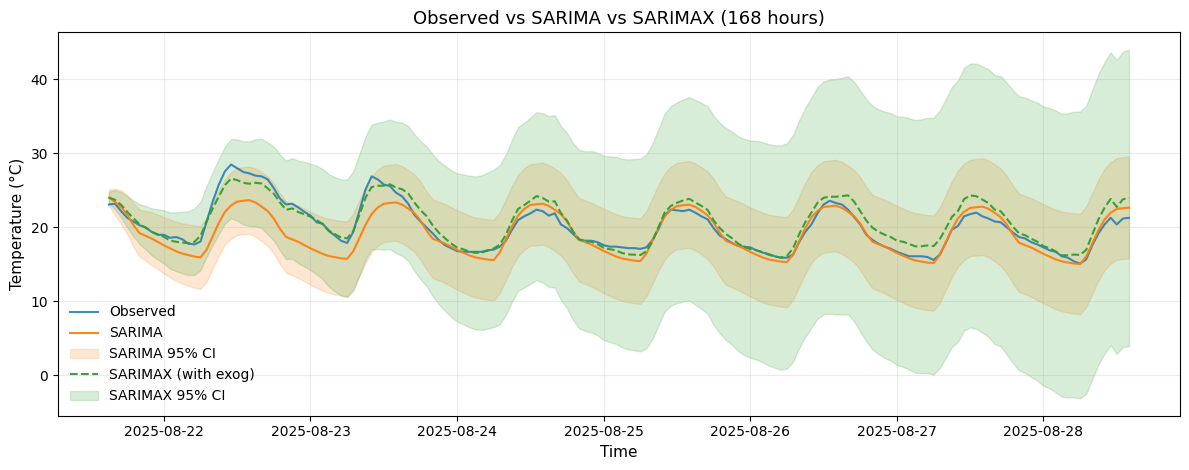

In [22]:
def overlay_sarima_vs_sarimax(
    sarima_results,
    sarimax_results,
    y_test: pd.Series,
    exog_test_s: pd.DataFrame,
    horizon: int = 168,
) -> None:
    idx = y_test.index[:horizon]

    # SARIMA
    fc_sarima = sarima_results.get_forecast(steps=horizon)
    sarima_mean = fc_sarima.predicted_mean.copy()
    sarima_ci = fc_sarima.conf_int().copy()
    sarima_mean.index = idx
    sarima_ci.index = idx

    # SARIMAX (needs exog for the forecast horizon)
    fc_sarimax = sarimax_results.get_forecast(steps=horizon, exog=exog_test_s.iloc[:horizon])
    sarimax_mean = fc_sarimax.predicted_mean.copy()
    sarimax_ci = fc_sarimax.conf_int().copy()
    sarimax_mean.index = idx
    sarimax_ci.index = idx

    # Plot
    plt.figure(figsize=(12, 4.8))
    plt.plot(y_test.iloc[:horizon], label="Observed", alpha=0.85)

    l1 = plt.plot(sarima_mean, label="SARIMA", alpha=0.95)[0]
    plt.fill_between(
        idx, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1],
        alpha=0.18, color=l1.get_color(), label="SARIMA 95% CI"
    )

    l2 = plt.plot(sarimax_mean, label="SARIMAX (with exog)", linestyle="--", alpha=0.95)[0]
    plt.fill_between(
        idx, sarimax_ci.iloc[:, 0], sarimax_ci.iloc[:, 1],
        alpha=0.18, color=l2.get_color(), label="SARIMAX 95% CI"
    )

    plt.title(f"Observed vs SARIMA vs SARIMAX ({horizon} hours)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.show()

overlay_sarima_vs_sarimax(final_results, sarimax_results, y_test, exog_test_s, horizon=168)

When comparing SARIMAX to SARIMA and the seasonal naïve baseline, it is common to see limited gains at 24–48 hours (where diurnal persistence dominates) but clearer gains at 7 days and beyond, where exogenous drivers help explain departures from simple repetition.


## Machine-learning baseline (lags + calendar features)

As a lightweight nonlinear benchmark, we train a gradient-boosted tree model on lagged temperature values and basic calendar features. This is not a full production forecasting pipeline, but it provides a useful reference for how much predictive signal exists in simple nonlinear relationships.


In [23]:
# Feature engineering
ml_df = df[["temperature_2m"]].copy()

for lag in [1, 2, 24, 48, 168]:
    ml_df[f"lag_{lag}"] = ml_df["temperature_2m"].shift(lag)

ml_df["hour"] = ml_df.index.hour
ml_df["dayofweek"] = ml_df.index.dayofweek
ml_df["month"] = ml_df.index.month

ml_df = ml_df.dropna()

X = ml_df.drop(columns="temperature_2m")
y_ml = ml_df["temperature_2m"]

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train_ml = y_ml.iloc[:split_idx]
y_test_ml = y_ml.iloc[split_idx:]

ml_model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=300,
    random_state=42,
)
ml_model.fit(X_train, y_train_ml)

,loss,'squared_error'
,quantile,None
,learning_rate,0.05
,max_iter,300
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [24]:
rows = []
for label, h in HORIZONS.items():
    preds = ml_model.predict(X_test.iloc[:h])
    y_true = y_test_ml.iloc[:h]
    rows.append(["ML (lags+calendar)", label, mean_absolute_error(y_true, preds), rmse(y_true, preds)])

ml_h = pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE"])
display(ml_h)

,Model,Horizon,MAE,RMSE
0,ML (lags+calendar),24h,0.206778,0.245068
1,ML (lags+calendar),48h,0.252608,0.311700
2,ML (lags+calendar),7d,0.273639,0.361029
3,ML (lags+calendar),2weeks,0.285327,0.369185


In [25]:
# Cross-validation
def _rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

# 5 splits
tscv = TimeSeriesSplit(n_splits=5)

cv_rows = []
oof_pred = pd.Series(index=X_train.index, dtype=float)

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    y_tr, y_va = y_train_ml.iloc[tr_idx], y_train_ml.iloc[va_idx]

    m = HistGradientBoostingRegressor(
        max_depth=6,
        learning_rate=0.05,
        max_iter=300,
        random_state=42,
    )
    m.fit(X_tr, y_tr)

    yhat_va = pd.Series(m.predict(X_va), index=X_va.index)
    oof_pred.loc[X_va.index] = yhat_va

    cv_rows.append({
        "fold": fold, "Horizon": "full_fold",
        "MAE": mean_absolute_error(y_va, yhat_va),
        "RMSE": _rmse(y_va, yhat_va),
        "n": len(y_va),
    })

    for label, h in HORIZONS.items():
        h_eff = min(h, len(y_va))
        cv_rows.append({
            "fold": fold, "Horizon": label,
            "MAE": mean_absolute_error(y_va.iloc[:h_eff], yhat_va.iloc[:h_eff]),
            "RMSE": _rmse(y_va.iloc[:h_eff], yhat_va.iloc[:h_eff]),
            "n": h_eff,
        })

ml_cv = pd.DataFrame(cv_rows)
display(ml_cv.groupby("Horizon")[["MAE","RMSE","n"]].agg(["mean","std"]))

MAE                RMSE                 n     
               mean       std      mean       std    mean  std
Horizon                                                       
24h        0.391406  0.099239  0.475892  0.072635    24.0  0.0
2weeks     0.472402  0.112740  0.695730  0.270665   336.0  0.0
48h        0.381861  0.102295  0.507388  0.153673    48.0  0.0
7d         0.429016  0.052981  0.588092  0.067875   168.0  0.0
full_fold  0.429505  0.028557  0.612840  0.047122  6942.0  0.0

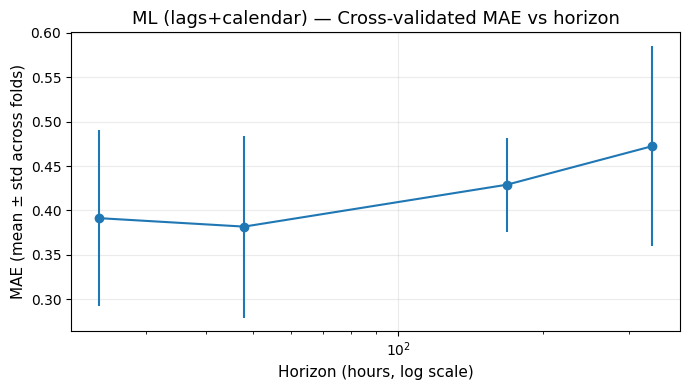

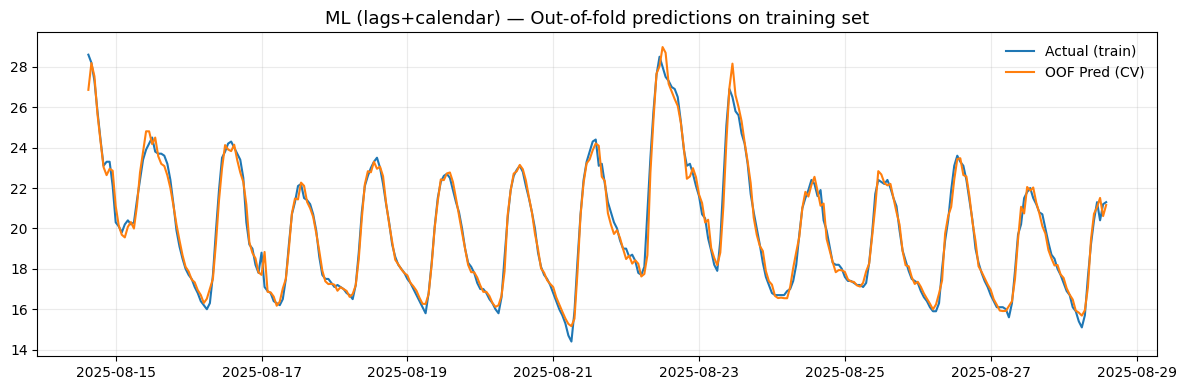

In [27]:
summary = (ml_cv[ml_cv["Horizon"] != "full_fold"]
           .groupby("Horizon")["MAE"].agg(["mean","std"])
           .reindex(list(HORIZONS.keys())))

hs = np.array([HORIZONS[k] for k in summary.index], dtype=float)

fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(hs, summary["mean"].values, yerr=summary["std"].values, marker="o", linestyle="-")
ax.set_xscale("log")
ax.set_xlabel("Horizon (hours, log scale)")
ax.set_ylabel("MAE (mean ± std across folds)")
ax.set_title("ML (lags+calendar) — Cross-validated MAE vs horizon")
plt.tight_layout()
plt.show()

plot_n = min(24*14, len(oof_pred.dropna()))
idx = oof_pred.dropna().index[-plot_n:]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_train_ml.loc[idx].index, y_train_ml.loc[idx].values, label="Actual (train)")
ax.plot(oof_pred.loc[idx].index, oof_pred.loc[idx].values, label="OOF Pred (CV)")
ax.set_title("ML (lags+calendar) — Out-of-fold predictions on training set")
ax.legend()
plt.tight_layout()
plt.show()

This model is strong mainly because lagged temperature features carry most of the signal; it’s closer to an advanced autoregressive baseline than a ‘black-box weather model’.

## 7-day comparison plot

To summarize model behavior on a realistic short horizon, we overlay observed temperature with forecasts from the seasonal naïve baseline, SARIMA, SARIMAX, and the ML model over the first 7 days of the test period.


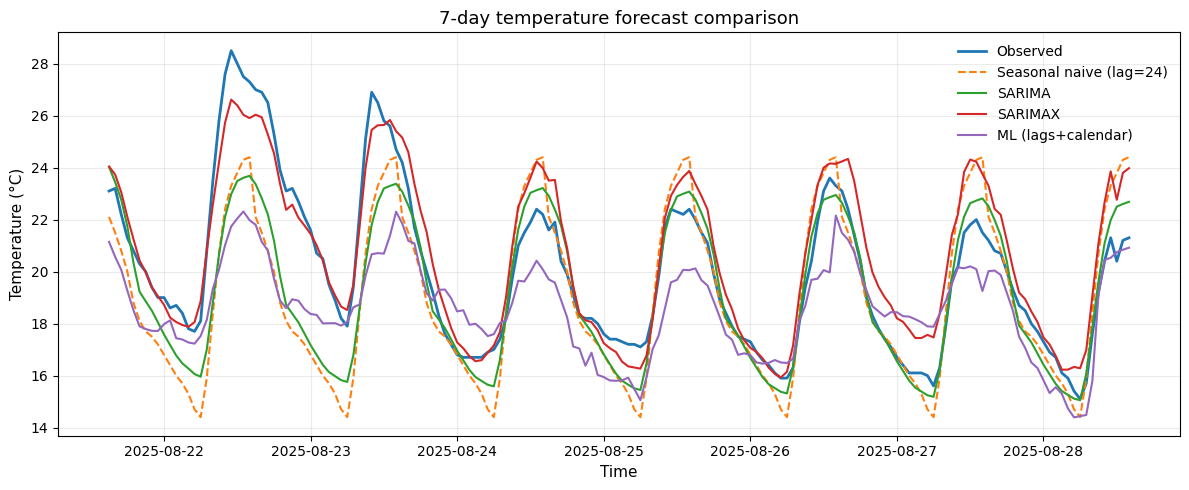

In [28]:
horizon = 168
idx = y_test.index[:horizon]

observed = y_test.iloc[:horizon]

snaive = seasonal_naive_series(y_train, y_test.index, horizon=horizon, season=24)

sarima_mean = final_results.get_forecast(steps=horizon).predicted_mean
sarima_mean.index = idx

sarimax_mean = sarimax_results.get_forecast(steps=horizon, exog=exog_test_s.iloc[:horizon]).predicted_mean
sarimax_mean.index = idx

ml_pred = pd.Series(ml_model.predict(X_test.iloc[:horizon]), index=idx)

plt.figure(figsize=(12, 5))
plt.plot(observed, label="Observed", linewidth=2)
plt.plot(snaive, label="Seasonal naive (lag=24)", linestyle="--")
plt.plot(sarima_mean, label="SARIMA")
plt.plot(sarimax_mean, label="SARIMAX")
plt.plot(ml_pred, label="ML (lags+calendar)")
plt.title("7-day temperature forecast comparison")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
tables = []
for name in ["results_h", "sarimax_h", "ml_h"]:
    if name in globals():
        tables.append(globals()[name].copy())
    else:
        print(f"Missing: {name}")

all_models_h = pd.concat(tables, ignore_index=True)

h_order = list(HORIZONS.keys())

comparison = (all_models_h
              .pivot_table(index="Model", columns="Horizon", values=["MAE", "RMSE"], aggfunc="mean")
              .reindex(columns=pd.MultiIndex.from_product([["MAE", "RMSE"], h_order])))

comparison = comparison.round(3)
display(comparison)

MAE                        RMSE                \
                           24h    48h     7d 2weeks    24h    48h     7d   
Model                                                                      
ML (lags+calendar)       0.207  0.253  0.274  0.285  0.245  0.312  0.361   
SARIMA                   2.309  2.987  1.290  1.296  2.882  3.368  1.909   
SARIMAX                  0.728  0.650  0.958  1.181  0.945  0.825  1.184   
Seasonal naive (lag=24)  2.933  3.508  1.684  1.674  3.215  3.792  2.282   

                                
                        2weeks  
Model                           
ML (lags+calendar)       0.369  
SARIMA                   1.781  
SARIMAX                  1.452  
Seasonal naive (lag=24)  2.159

## Summary

The data exhibit strong daily (24h) and annual seasonality. After applying first and seasonal differencing, ACF/PACF diagnostics motivate a compact SARIMA specification with daily seasonal terms. Candidate models are compared using AIC/BIC, and the selected SARIMA model passes basic residual checks with no obvious remaining seasonal structure. Forecast uncertainty increases with horizon, so model performance is best discussed using short-horizon plots and horizon-specific error metrics.

A seasonal naïve baseline is highly competitive at 24–48 hours due to strong diurnal persistence. More flexible models (SARIMA/SARIMAX) become more beneficial as the horizon grows. Adding exogenous drivers can improve longer-horizon accuracy, and a simple ML benchmark shows how much additional signal can be captured when nonlinear relationships are allowed.
